In [ ]:
import pandas as pd
import google.generativeai as genai
import os
import chromadb
import uuid
from collections import Counter 
import random
from dotenv import load_dotenv
import openai
import time
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# >>>>READ<<<<: 
# ADD GOOGLE API KEY in ./.env file
# GOOGLE_API_KEY=...
load_dotenv()

True

In [3]:
# init
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")
# prepare google genai
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
# prepare groq client
groq_client = openai.OpenAI(
    base_url="https://api.groq.com/openai/v1",
    api_key=os.environ["GROQ_KEY"]
)

In [4]:
# prepare dataset for embeddings
# new doc
def mod_func(row):
    row['document'] = f"""The following complaint document written by a user is categorized as '{row.category}' and sub-categorized as '{row.sub_category}':
{row.crimeaditionalinfo}
    """
    return row

train_data['sub_category'] = train_data['sub_category'].fillna(train_data['category'])
# prepared_train_data =  train_data.apply(mod_func, axis=1)

train_data['combined_length'] = train_data['category'].fillna('').str.len() + \
                        train_data['sub_category'].fillna('').str.len() + \
                        train_data['crimeaditionalinfo'].fillna('').str.len()
train_data

,category,sub_category,crimeaditionalinfo,combined_length
0,Online and Social Media Related Crime,Cyber Bullying Stalking Sexting,I had continue received random calls and abusi...,328
1,Online Financial Fraud,Fraud CallVishing,The above fraudster is continuously messaging ...,286
2,Online Gambling Betting,Online Gambling Betting,He is acting like a police and demanding for m...,277
3,Online and Social Media Related Crime,Online Job Fraud,In apna Job I have applied for job interview f...,591
4,Online Financial Fraud,Fraud CallVishing,I received a call from lady stating that she w...,233
...,...,...,...,...
93681,Online Financial Fraud,Internet Banking Related Fraud,Identity theft Smishing SMS Fraud CreditDeb...,326
93682,Online Financial Fraud,EWallet Related Fraud,RECEIVED CALL FROM NUMBER ASKING ABOUT phone ...,238
93683,Online Financial Fraud,UPI Related Frauds,Cyber Stalking Blackmailing PhoneSMSVOIP C...,252
93684,Online and Social Media Related Crime,Online Matrimonial Fraud,Call karke bola ki aapka lotary laga ha aru AC...,292


In [5]:
# sanity check that if any row exceeds embeddings context length
embeddings_context_length = 2048
if len(train_data[train_data.combined_length > embeddings_context_length]) > 1:
    train_data[train_data.combined_length > embeddings_context_length]
else:
    print("Success! All rows are within the context length.")

Success! All rows are within the context length.


In [7]:
def predict_categories(document,sample_size = 1,collection=embeddings_collection):
    predicted_category = ""
    predicted_scategory = ""
    result = genai.embed_content(model="models/text-embedding-004", content=[document])
    test_embeddings = result['embedding'][0]
    # query db
    query_result = collection.query(query_embeddings=test_embeddings,n_results=sample_size)
    # print results
    sampled_categories = []
    sampled_scategories = []
    for i in range(sample_size):
        if 'category' in query_result['metadatas'][0][0]:
            sampled_categories.append(query_result['metadatas'][0][0]['category'])
        else:
            sampled_categories.append(None)
    
    # get the most occurred
    predicted_category = Counter(sampled_categories).most_common(1)[0][0]
    
    # get sub category
    # query db
    query_result = collection.query(query_embeddings=test_embeddings,n_results=sample_size,where={"category":predicted_category})
       
    if 'scategory' in query_result['metadatas'][0][0]:
        sampled_scategories.append(query_result['metadatas'][0][0]['scategory'])
    else:
        sampled_scategories.append(None)

    predicted_scategory = Counter(sampled_scategories).most_common(1)[0][0]
    return (predicted_category,predicted_scategory,sampled_categories,sampled_scategories)

In [51]:
%%script true
# >>>>PLEASE READ!!!!!<<<<
# THIS CELL EXECUTION SHOULD BE A ONE TIME PROCESS
# REMOVE THE ABOVE "%%SCRIPT TRUE" TO RUN THIS CELL
# THIS CELL PREPARES AND POPULATES ALL THE VECTOR EMBEDDINGS OF THE TRAIN DATA
# 
step = 200
max_length = len(train_data)
for i in range(0, max_length, step):
    start_idx = i
    end_idx = i + step
    documents = []
    metadatas = []
    document_ids = []
    for index, row in train_data[start_idx:end_idx].iterrows():
        doc_ = f"""The following complaint document written by a user is categorized as '{row.category}' and sub-categorized as '{row.sub_category}':
{row.crimeaditionalinfo}"""
        documents.append(doc_)
        metadatas.append({"category": row.category, "scategory": row.sub_category})
        document_ids.append(str(uuid.uuid4()))

    result = genai.embed_content(model="models/text-embedding-004", content=documents)

    print("inserting results in vectordb")
    embeddings = result["embedding"]
    data_to_insert = embeddings_collection.add(
        documents=documents,
        metadatas=metadatas,
        ids=document_ids,
        embeddings=embeddings,
    )
    print(f"data inserted from index {start_idx} to {end_idx}")
print("Vector embeddings prepared...")

In [ ]:
# TEST SINGLE
test_idx = int(len(test_data)*random.random())
row = test_data.iloc[test_idx]
print(f"Expected Category: {row.category}")
print(f"Expected Sub-category: {row.sub_category}")
print(f"Complaint: {row.crimeaditionalinfo}")
print()
predict_category,predict_scategory,sampled_categories,sampled_scategories  = predict_categories(f"""The following complaint document written by a user:
{row.crimeaditionalinfo}""",10)
print(sampled_categories)
print(sampled_scategories)
print()
print(f"Predicted Category: {predict_category}")
print(f"Predicted Sub-category: {predict_scategory}")

In [ ]:
# TEST ALL
sample_size = 10
test_test_data = test_data.sample(n=sample_size).reset_index(drop=True)
failure_indexes = []
failure_indexes_category = []
failure_indexes_scategory = []
failure_predicted_categories = []
for index, row in test_test_data.iterrows():
    print(f"{index+1}/{sample_size}",end='\r')
    document = f"""The following complaint document written by a user:
{row.crimeaditionalinfo}"""
    predict_category,predict_scategory,sampled_categories,sampled_scategories = predict_categories(document,10)
    
    if row.category == predict_category:
        if row.sub_category == predict_scategory or pd.isna(row.sub_category) or row.sub_category == None:
            
            continue
        else:
            # print("Failed Sub-category---------")
            # print(f"Index: {index}")
            # print(f"Expected: {row.sub_category}")
            # print(f"Predicted: {predict_scategory}")
            # print("----------------------------")
            failure_indexes_scategory.append(index)
    else:
        print("Failed Category-------------")
        print(f"Index: {index}")
        print(f"Expected: {row.category}")
        print(f"Predicted: {predict_category}")
        print("----------------------------")
        failure_indexes_category.append(index)
    
    failure_predicted_categories.append([predict_category,predict_scategory])
    failure_indexes.append(index)
        
print(f"Success Rate Overall: {100 - len(failure_indexes)/sample_size*100}%") 
print(f"Success Rate (Category only): {100 - len(failure_indexes_category)/sample_size*100}%") 
print(f"Success Rate (Sub-category only): {100 - len(failure_indexes_scategory)/sample_size*100}%") 

# Summarised Embeddings

In [12]:
def prepare_paragraph(category,sub_category,sample_size=10):
    cat_1 = train_data[(train_data.category == category) & (train_data.sub_category == sub_category)].sample(n=sample_size).reset_index(drop=True)
    complaints = ""
    for index, row in cat_1.iterrows(): 
        if pd.isna(row.crimeaditionalinfo) or row.crimeaditionalinfo == None:
            continue
        complaints += f"\nComplaint {index+1}:\n" + row.crimeaditionalinfo + "\n\n"
        
    # processed = f"""Following are the user written complaints. Please tranform all the complaints to paragraphs such that it retains a general idea about the complaints and is ideal for vector embeddings. Please respond only with text, no markdown.
    #     {complaints}
    # """

    processed = f"""You are a cybersecurity incident analyst tasked with summarizing (in pure text) multiple user complaints about potential cyber issues written in english or hinglish. The complaints are written by users in India and the context of the complains are exclusively Indian. Your goal is to create a concise summary that captures the main concerns and patterns across all complaints while retaining the essential details.

Please provide a summary of the following user complaints, highlighting:

1. Common issues or themes
2. Specific types of cyber threats mentioned
3. Any patterns in affected systems or devices
4. Potential impact on users or organizations
5. Any unusual or standout complaints

Instructions to follow:
1. Please respond only with text, NO markdown.
2. If the language is not english then preserve the language elements.

Combine similar complaints and present the information in a clear, organized manner. Your summary should give a comprehensive overview of the situation without losing important details from individual complaints. 

User complaints:

{complaints}
    """

    return processed

In [13]:
def genai_predict(input_text):
    # system_instruction = "Do not respond in markdown, respond only with pure text, it can have paragraphs."
    system_instruction = ""
    model = genai.GenerativeModel('gemini-1.5-flash')
    response = model.generate_content(input_text)
    res_content = response.candidates[0].content
    res_part = res_content.parts[0]
    res_text = res_part.text
    res_text.replace("*","")
    return res_text,response._error

In [14]:
def groq_predict(input_text):
    # system_instruction = "Do not respond in markdown, respond only with pure text, it can have paragraphs."
    system_instruction = ""
    chat_completion = groq_client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": system_instruction,
        },
        {
            "role": "user",
            "content": input_text,
        },
    ],
    model="llama-3.2-90b-text-preview",
)
    res_text = chat_completion.choices[0].message.content
    res_text.replace("*","")
    return res_text,None

In [15]:
def sample_and_summarise_categories(category,sub_category,sample_size=10,llm_channel="genai"):
    
    if llm_channel == "genai":
        summary_,err = genai_predict(prepare_paragraph(category,sub_category))
    elif llm_channel == "groq":
        summary_,err = groq_predict(prepare_paragraph(category,sub_category))
    
    if err is not None:
        print(err)
    documents = []
    metadatas = []
    document_ids = []

    metadatas.append({"category": category, "scategory": sub_category})
    documents.append(summary_)
    document_ids.append(str(uuid.uuid4()))
    
    result = genai.embed_content(model="models/text-embedding-004", content=documents)
    
    print("inserting results in summed collection")
    embeddings = result["embedding"]
    embeddings_collection_summed.add(
        documents=documents,
        metadatas=metadatas,
        ids=document_ids,
        embeddings=embeddings,
    )
    print(f"data inserted")

In [ ]:
# %%script true
# >>>>PLEASE READ!!!!!<<<<
# THIS CELL EXECUTION SHOULD BE A ONE TIME PROCESS
# REMOVE THE ABOVE "%%SCRIPT TRUE" TO RUN THIS CELL
# THIS CELL PREPARES AND POPULATES ALL THE VECTOR EMBEDDINGS OF THE TRAIN DATA
# 
# # prepare data based on summarisation
skip_categories = ['RapeGang Rape RGRSexually Abusive Content','Sexually Explicit Act','Sexually Obscene material','Child Pornography CPChild Sexual Abuse Material CSAM']
categories = train_data.groupby('category')['sub_category'].agg(lambda x: sorted(set(x))).to_dict()
# sub_categories = train_data.sub_category.unique()
failures = []

for cat in categories:
    # llm_channel = "genai"
    llm_channel = "groq"
    if cat in skip_categories:
        llm_channel = "groq"
    for scat in categories[cat]:
        print(f"Doing for {cat} and {scat} using {llm_channel} ...")
        try:
            # do for 5 times
            sample_and_summarise_categories(cat,scat,10,llm_channel=llm_channel)
            time.sleep(1)
        except Exception as e:
            print(e)
            print(f"FAILED!")
            failures.append((cat,scat))

In [ ]:
failures

In [ ]:
# TEST SINGLE
test_idx = int(len(test_data)*random.random())
row = test_data.iloc[test_idx]
print(f"Index: {test_idx}")
print(f"Expected Category: {row.category}")
print(f"Expected Sub-category: {row.sub_category}")
print(f"Complaint: {row.crimeaditionalinfo}")
print()
predict_category,predict_scategory,sampled_categories,sampled_scategories  = predict_categories(f"""The following complaint document written by a user:
{row.crimeaditionalinfo}""",10,collection=embeddings_collection_summed)
print(sampled_categories)
print(sampled_scategories)
print()
print(f"Predicted Category: {predict_category}")
print(f"Predicted Sub-category: {predict_scategory}")

In [ ]:
# TEST ALL
sample_size = 100
test_test_data = test_data.sample(n=sample_size).reset_index(drop=True)
failure_indexes = []
failure_indexes_category = []
failure_indexes_scategory = []
failure_predicted_categories = []
for index, row in test_test_data.iterrows():
    print(f"{index+1}/{sample_size}",end='\r')
    document = f"""The following complaint document written by a user:
{row.crimeaditionalinfo}"""
    predict_category,predict_scategory,sampled_categories,sampled_scategories = predict_categories(document,10,collection=embeddings_collection_summed)
    
    if row.category == predict_category:
        if row.sub_category == predict_scategory or pd.isna(row.sub_category) or row.sub_category == None:
            
            continue
        else:
            # print("Failed Sub-category---------")
            # print(f"Index: {index}")
            # print(f"Expected: {row.sub_category}")
            # print(f"Predicted: {predict_scategory}")
            # print("----------------------------")
            failure_indexes_scategory.append(index)
    else:
        print("Failed Category-------------")
        print(f"Index: {index}")
        print(f"Expected: {row.category}")
        print(f"Predicted: {predict_category}")
        print("----------------------------")
        failure_indexes_category.append(index)
    
    failure_predicted_categories.append([predict_category,predict_scategory])
    failure_indexes.append(index)
        
print(f"Success Rate Overall: {100 - len(failure_indexes)/sample_size*100}%") 
print(f"Success Rate (Category only): {100 - len(failure_indexes_category)/sample_size*100}%") 
print(f"Success Rate (Sub-category only): {100 - len(failure_indexes_scategory)/sample_size*100}%") 

In [ ]:
test_test_data.iloc[2].crimeaditionalinfo

# Embedding Average

In [7]:
categories = train_data.groupby('category')['sub_category'].agg(lambda x: sorted(set(x))).to_dict()
# del categories['Any Other Cyber Crime'] # TODO: !!???

# categories = {"Child Pornography CPChild Sexual Abuse Material CSAM":['Child Pornography CPChild Sexual Abuse Material CSAM']}

In [ ]:
%%script true
# >>>>PLEASE READ!!!!!<<<<
# THIS CELL EXECUTION SHOULD BE A ONE TIME PROCESS
# REMOVE THE ABOVE "%%SCRIPT TRUE" TO RUN THIS CELL
# THIS CELL PREPARES AND POPULATES ALL THE AVERGAE VECTOR EMBEDDINGS OF THE TRAIN DATA
# average_embeddings.json in the repo already contains the averaged data so no need to execute this cell
# 
final_embeddings = {}
step = 200
for cat in categories:
    for scat in categories[cat]:
        print(f"Doing for {cat} and {scat} ...")
        specific_data = train_data[(train_data.category == cat) & (train_data.sub_category == scat)]
        max_length = len(specific_data)
        embeddings_all = []
        for i in range(0, max_length, step):
            start_idx = i
            end_idx = i + step
            documents = []
            metadatas = []
            document_ids = []
            print(f"{start_idx}-{end_idx}/{max_length}",end='\r')
            for index, row in specific_data[start_idx:end_idx].iterrows():
                doc_ = f"""The following complaint document written by a user is categorized as '{row.category}' and sub-categorized as '{row.sub_category}':
{row.crimeaditionalinfo}"""
                documents.append(doc_)
                metadatas.append({"category": row.category, "scategory": row.sub_category})
                document_ids.append(str(uuid.uuid4()))

            result = genai.embed_content(model="models/text-embedding-004", content=documents)

            embeddings_all.extend(result['embedding'])
        print()
        # do mean
        average_embeddings = np.mean(embeddings_all,axis=0)
        if cat not in final_embeddings:
            final_embeddings[cat] = {}
        if scat not in final_embeddings[cat]:
            final_embeddings[cat][scat] = []
            
        final_embeddings[cat][scat] = average_embeddings.tolist()
    
# save to file
f = open("./average_embeddings.json",'w')
json.dump(final_embeddings,f)
f.close()

In [12]:
def get_closest_embeddings(query_embedding, embedding_list,n_sorted=10):
    """
    Find the closest embeddings from a list of embeddings, sorted by similarity.
    
    Args:
    query_embedding (np.array): The embedding to compare against.
    embedding_list (list): List of embeddings to search through.
    
    Returns:
    tuple: (closest_embedding, index, similarity_score, sorted_embeddings, sorted_indices)
    """
    # Convert the query embedding to a 2D array
    query_embedding = np.array(query_embedding).reshape(1, -1)
    
    # Convert the list of embeddings to a 2D array
    embedding_array = np.array(embedding_list)
    
    # Compute cosine similarities
    similarities = cosine_similarity(query_embedding, embedding_array)[0]
    
    # Sort similarities in descending order and get sorted indices
    sorted_indices = np.argsort(similarities)[::-1]
    
    # Get the closest embedding, its index, and similarity score
    closest_index = sorted_indices[0]
    closest_embedding = embedding_list[closest_index]
    similarity_score = similarities[closest_index]
    
    # Create a list of tuples (embedding, original_index, similarity_score)
    sorted_embeddings = [(embedding_list[i], i, similarities[i]) for i in sorted_indices]
    
    return closest_embedding, closest_index, similarity_score, sorted_embeddings[:n_sorted], sorted_indices[:n_sorted]


In [13]:
# read final embeddings and prepare list
f = open("./average_embeddings.json",'r')
average_embeddings_dict = json.load(f)
average_embeddings_embeddings_list = []
average_embeddings_pair_list = []
f.close()
# prepare list and sub pairs
for i in average_embeddings_dict:
    for j in average_embeddings_dict[i]:
        average_embeddings_embeddings_list.append(average_embeddings_dict[i][j])
        average_embeddings_pair_list.append((i,j))

In [77]:
def predict_from_average_embeddings(document,embeddings_list=average_embeddings_embeddings_list,pair_list=average_embeddings_pair_list,sample_size = 10,top_k=3):
    result = genai.embed_content(model="models/text-embedding-004", content=[document])
    test_embeddings = result['embedding'][0]
    closest_embedding, closest_index, similarity_score, sorted_embeddings, sorted_indices = get_closest_embeddings(test_embeddings,embeddings_list,sample_size)
    
    predicted_pairs = [pair_list[i] for i in sorted_indices]
    
    # predicted_pair = Counter(predicted_pairs).most_common(1)[0][0]
    # print(predicted_pair)
    return predicted_pairs[:top_k]
    

In [ ]:
# TEST SINGLE
test_idx = int(len(test_data)*random.random())
row = test_data.iloc[test_idx]
print(f"Index: {test_idx}")
print(f"Expected Category: {row.category}")
print(f"Expected Sub-category: {row.sub_category}")
print(f"Complaint: {row.crimeaditionalinfo}")
print()
predicted_pairs  = predict_from_average_embeddings(f"""The following complaint document written by a user:
{row.crimeaditionalinfo}""",sample_size=10)
print()
print(f"---- K = 1 ----")
print(f"Predicted Category: {predicted_pairs[0][0]}")
print(f"Predicted Sub-category: {predicted_pairs[0][1]}")
print(f"---- K = 2 ----")
print(f"Predicted Category: {predicted_pairs[1][0]}")
print(f"Predicted Sub-category: {predicted_pairs[1][1]}")
print(f"---- K = 3 ----")
print(f"Predicted Category: {predicted_pairs[2][0]}")
print(f"Predicted Sub-category: {predicted_pairs[2][1]}")

In [ ]:
# TEST ALL
sample_size = 100
test_test_data = test_data.sample(n=sample_size).reset_index(drop=True)
failure_indexes = []
failure_indexes_category = []
failure_indexes_scategory = []
failure_predicted_categories = []
for index, row in test_test_data.iterrows():
    print(f"{index+1}/{sample_size}",end='\r')
    document = f"""The following complaint document written by a user:
{row.crimeaditionalinfo}"""
    predicted_pairs = predict_from_average_embeddings(document,sample_size=10)
    predict_category = predicted_pairs[0][1]
    predict_scategory= predicted_pairs[0][1]
    if row.category == predict_category:
        if row.sub_category == predict_scategory or pd.isna(row.sub_category) or row.sub_category == None:
            
            continue
        else:
            # print("Failed Sub-category---------")
            # print(f"Index: {index}")
            # print(f"Expected: {row.sub_category}")
            # print(f"Predicted: {predict_scategory}")
            # print("----------------------------")
            failure_indexes_scategory.append(index)
    else:
        print("Failed Category-------------")
        print(f"Index: {index}")
        print(f"Expected: {row.category}")
        print(f"Predicted: {predict_category}")
        print("----------------------------")
        failure_indexes_category.append(index)
    
    failure_predicted_categories.append([predict_category,predict_scategory])
    failure_indexes.append(index)
        
print(f"Success Rate Overall: {100 - len(failure_indexes)/sample_size*100}%") 
print(f"Success Rate (Category only): {100 - len(failure_indexes_category)/sample_size*100}%") 
print(f"Success Rate (Sub-category only): {100 - len(failure_indexes_scategory)/sample_size*100}%") 

# PERFORMANCE METRICS

### Recall

In [ ]:
def recall_calculate(data,top_k=3):
    start_time = time.time_ns()
    false_negatives_c = 0
    true_positives_c = 0
    false_negatives_s = 0
    true_positives_s = 0
    for index, row in data.iterrows():
        print(f"{index+1}/{len(data)}",end='\r')
        document = f"""{row.crimeaditionalinfo}"""
        predicted_pairs = predict_from_average_embeddings(document,sample_size=10,top_k=top_k)
        
        # get pairs with correct category.
        correct_category_pairs=[]
        target_pair = None
        for pair in predicted_pairs:
            if pair[0] == row.category:
                correct_category_pairs.append(pair)
        # check sub categories
        for pair in correct_category_pairs:
            if pair[1] == row.sub_category or pd.isna(row.sub_category) or row.sub_category == None:
                target_pair = pair
                
        if target_pair is not None:
            true_positives_c += 1
            true_positives_s += 1
            continue
        if len(correct_category_pairs) > 0:
            true_positives_c += 1
            false_negatives_s += 1
            continue
        
        # failed to get correct prediction
        false_negatives_c += 1

            
    calculated_recall_category = true_positives_c/(true_positives_c+false_negatives_c)
    calculated_recall_subcategory = true_positives_s/(true_positives_s+false_negatives_s)
    end_time = time.time_ns()
    time_taken  = end_time-start_time
    print(f"Recall (Category): {calculated_recall_category}")
    print(f"Recall (Subcategory): {calculated_recall_subcategory}")
    print(f"Time Taken Total(s): {time_taken / 1e9}")
    print(f"Time Taken Per Row(ms): {time_taken / 1e6 / len(data)}")
    return calculated_recall_category,calculated_recall_subcategory,time_taken
    

In [116]:
# TOP K = 1
recall_data_k_1 = recall_calculate(test_data.sample(n=250).reset_index(drop=True),top_k=1)

Recall (Category): 0.692
Recall (Subcategory): 0.5260115606936416
Time Taken Total(s): 106.666098446
Time Taken Per Row(ms): 426.664393784


In [117]:
# TOP K = 2
recall_data_k_2 = recall_calculate(test_data.sample(n=250).reset_index(drop=True),top_k=2)

Recall (Category): 0.776
Recall (Subcategory): 0.6443298969072165
Time Taken Total(s): 106.45823391
Time Taken Per Row(ms): 425.83293563999996


In [118]:
# TOP K = 3
recall_data_k_3 = recall_calculate(test_data.sample(n=250).reset_index(drop=True),top_k=3)

Recall (Category): 0.816
Recall (Subcategory): 0.6764705882352942
Time Taken Total(s): 106.87987955
Time Taken Per Row(ms): 427.5195182


In [119]:
# TOP K = 4
recall_data_k_4 = recall_calculate(test_data.sample(n=250).reset_index(drop=True),top_k=4)

Recall (Category): 0.84
Recall (Subcategory): 0.719047619047619
Time Taken Total(s): 106.500870331
Time Taken Per Row(ms): 426.003481324


In [120]:
# TOP K = 5
recall_data_k_5 = recall_calculate(test_data.sample(n=250).reset_index(drop=True),top_k=5)

Recall (Category): 0.904
Recall (Subcategory): 0.7876106194690266
Time Taken Total(s): 110.56127186
Time Taken Per Row(ms): 442.24508743999996


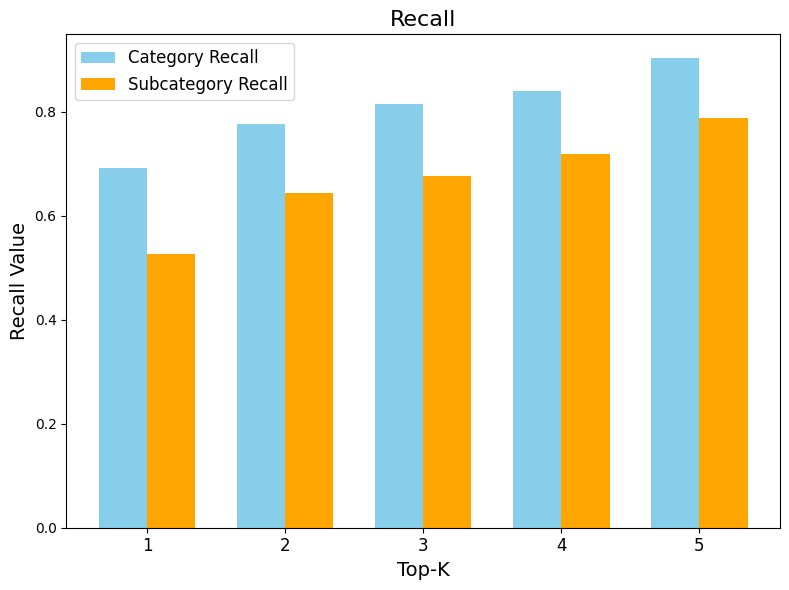

In [131]:
data = [
    {
        "k":1,
        "category":recall_data_k_1[0],
        "subcategory":recall_data_k_1[1],
    },
    {
        "k":2,
        "category":recall_data_k_2[0],
        "subcategory":recall_data_k_2[1],
    },
    {
        "k":3,
        "category":recall_data_k_3[0],
        "subcategory":recall_data_k_3[1],
    },
    {
        "k":4,
        "category":recall_data_k_4[0],
        "subcategory":recall_data_k_4[1],
    },
    {
        "k":5,
        "category":recall_data_k_5[0],
        "subcategory":recall_data_k_5[1],
    }
]
df = pd.DataFrame(data)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
x = df['k']

# Plotting both category and subcategory recalls
ax.bar(x - bar_width/2, df['category'], bar_width, label='Category Recall', color='skyblue')
ax.bar(x + bar_width/2, df['subcategory'], bar_width, label='Subcategory Recall', color='orange')

# Adding titles and labels
ax.set_title('Recall', fontsize=16)
ax.set_xlabel('Top-K', fontsize=14)
ax.set_ylabel('Recall Value', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=12)
ax.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()